In [1]:
from os import getcwd
from os.path import dirname, join

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import scipy.linalg as la
from matplotlib import cm

from MAMMAL import Diurnal
from MAMMAL.MapLvl import pcaLvl
from MAMMAL.MapLvl import tieLvl
from MAMMAL.Parse import parseGSMP as pgsmp
from MAMMAL.Parse import parseIM as pim
from MAMMAL.Parse import parseLCM as plcm
from MAMMAL.Utils import coordinateUtils as cu
from MAMMAL.Utils import Filters as filt
from MAMMAL.Utils import mapUtils as mu
from MAMMAL.Utils import ProcessingUtils as pu
from MAMMAL.VehicleCal import magUtilsTL as magtl


%matplotlib inline
plt.rcParams["figure.figsize"] = (30, 15) # (w, h)
plt.style.use(['seaborn-poster', 'seaborn-white'])
pd.set_option('mode.chained_assignment', None)

shrink = 0.8
aspect = 20 * 0.7
xlims  = [-86.028, -85.9927]
ylims  = [39.3050, 39.35]
cmap   = cm.coolwarm
s      = 10
alpha  = 0.85


GMAP_EXTENT = [-86.067298, -85.952393, 39.302228, 39.349337]

SURVEY_DIR = getcwd()
IN_DIR     = join(SURVEY_DIR, 'input_data')
GMAP_FNAME = join(IN_DIR, 'atterbury_large.jpg')
REF_FNAME  = join(IN_DIR, 'Ground_Reference.csv')
LOG_FNAME  = join(IN_DIR, '__4k_atterbury_survey__.csv')
OUT_DIR    = join(SURVEY_DIR, 'output_data')

SURVEY_NAME = '4km Atterbury Survey'

MAX_TERRAIN_MSL   = 230 # (m)
MAX_SURVEY_AGL    = 400 # (m)
MAX_SURVEY_CRUISE = 30  # (m/s)

MAX_EXPECTED_FREQ = MAX_SURVEY_CRUISE / MAX_SURVEY_AGL # (hz)

TL_C     = np.array([-1.86687725e+01,  1.33975396e+02, -1.80762945e+02,  1.69023832e-01,
                     -3.92262356e-03, -1.84382741e-03,  1.71830230e-01, -1.61173781e-04,
                      1.72575427e-01, -4.31927864e-04, -8.21512835e-05, -4.37609432e-05,
                     -1.06838978e-04, -1.22444017e-04, -2.76294434e-04, -8.51727772e-05,
                      3.16374022e-05, -2.77441572e-05])
TL_TERMS = magtl.DEFAULT_TL_TERMS
TL_COEFF_TYPES = ['Permanent', 'Induced', 'Eddy']

SCALAR_TYPE = 'Geometrics MFAM optically pumped caesium scalar magnetometer with 2 sensor heads'
VECTOR_TYPE = 'TwinLeaf VMR anisotropic magnetoresistive vector magnetometer'

FINAL_FILT_CUT   = MAX_SURVEY_AGL
FINAL_FILT_ORDER = 6

DX = 10 # Map pixel width (m)
DY = 10 # Map pixel height (m)

POC = '''Autonomy and Navigation Technology Center
         Air Force Institute of Technology
         Graduate School of Engineering and Management
         2950 Hobson Way, Bldg 646, Rm 205
         Wright Patterson AFB, Ohio 45433
         
         Telephone: (937) 255-3636 Ext. 4671'''

PROCESS_APP = 'MAMMAL 0.0.1'

# Load Survey Data

In [2]:
img = mpimg.imread(GMAP_FNAME)

ref_df = pd.read_csv(REF_FNAME, parse_dates=['datetime'])

log_df      = pd.read_csv(LOG_FNAME, parse_dates=['datetime'])
datetimes   = log_df.datetime
timestamps  = np.array(log_df.epoch_sec)
sample_rate = 1.0 / np.diff(timestamps).mean()

# Interpolate Reference Data

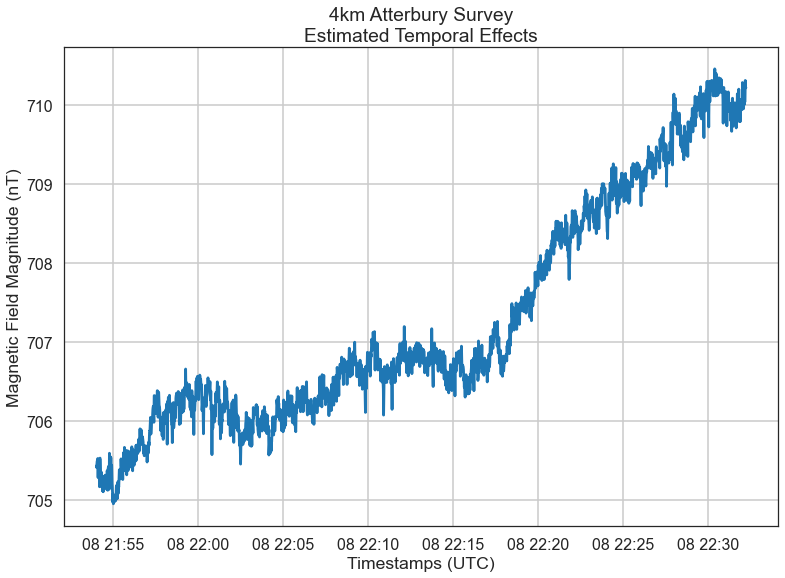

In [3]:
# Despike reference data
span  = 10
delta = 0.5

ref_despiked = pu.remove_outliers(ref_df.F, pu.ewma_fb(ref_df.F, span), delta)

ref_df.F = ref_despiked
ref_df.F = ref_df.F.interpolate()

# Interpolate reference data
_, ref_mag = Diurnal.interp_reference_df(df            = ref_df,
                                         timestamps    = timestamps,
                                         survey_lon    = log_df.LONG.mean(),
                                         subtract_core = True)

plt.figure()
plt.title('{}\nEstimated Temporal Effects'.format(SURVEY_NAME))
plt.xlabel('Timestamps (UTC)')
plt.ylabel('Magnetic Field Magnitude (nT)')
plt.plot(log_df.datetime, ref_mag)
plt.grid()

# Determine When Each Sensor Head was Valid During the Survey

(39.305, 39.35)

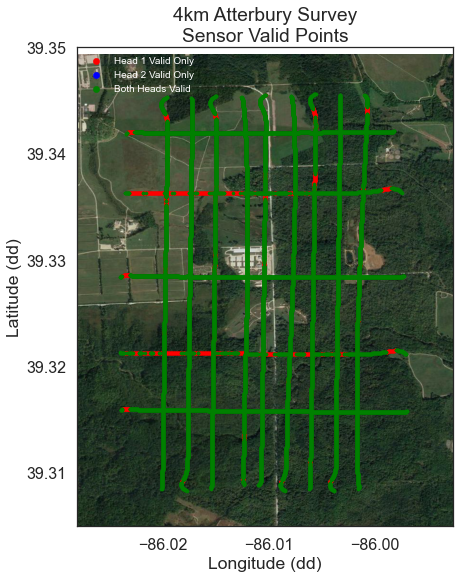

In [4]:
plt.figure()
plt.title('{}\nSensor Valid Points'.format(SURVEY_NAME))
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.imshow(img, extent=GMAP_EXTENT)
plt.scatter(log_df.LONG[(log_df.SCALAR_1_VALID == 1) & (log_df.SCALAR_2_VALID == 0) & (log_df.LINE_TYPE != 0)],
            log_df.LAT[(log_df.SCALAR_1_VALID == 1) & (log_df.SCALAR_2_VALID == 0) & (log_df.LINE_TYPE != 0)],
            s=s,
            c='r',
            label='Head 1 Valid Only')
plt.scatter(log_df.LONG[(log_df.SCALAR_1_VALID == 0) & (log_df.SCALAR_2_VALID == 1) & (log_df.LINE_TYPE != 0)],
            log_df.LAT[(log_df.SCALAR_1_VALID == 0) & (log_df.SCALAR_2_VALID == 1) & (log_df.LINE_TYPE != 0)],
            s=s,
            c='b',
            label='Head 2 Valid Only')
plt.scatter(log_df.LONG[(log_df.SCALAR_1_VALID == 1) & (log_df.SCALAR_2_VALID == 1) & (log_df.LINE_TYPE != 0)],
            log_df.LAT[(log_df.SCALAR_1_VALID == 1) & (log_df.SCALAR_2_VALID == 1) & (log_df.LINE_TYPE != 0)],
            s=s,
            c='g',
            label='Both Heads Valid')
plt.legend(labelcolor='white', fontsize='medium', markerscale=2)
plt.xlim(xlims)
plt.ylim(ylims)

# Apply Tolles Lawson Calibration

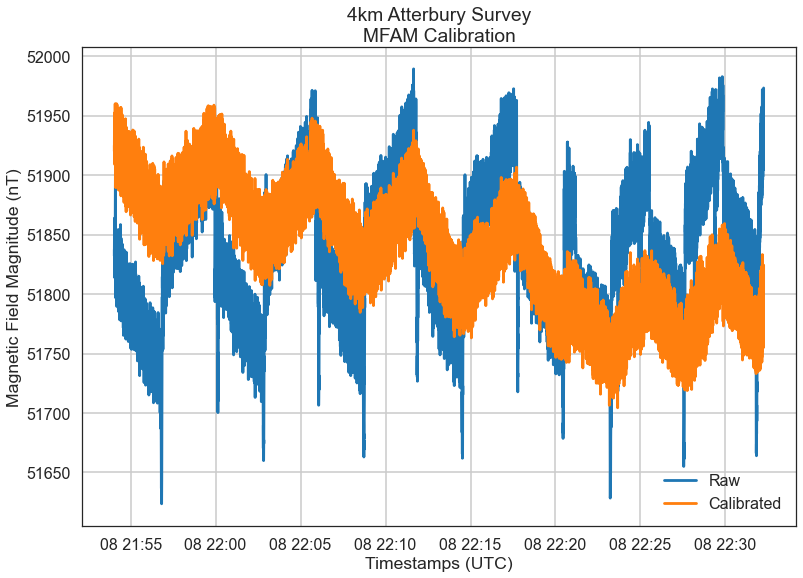

In [5]:
# Compile vector data
b_vector = np.hstack([np.array(log_df.X)[:, np.newaxis], 
                      np.array(log_df.Y)[:, np.newaxis],
                      np.array(log_df.Z)[:, np.newaxis]])

dcs  = b_vector / la.norm(b_vector, axis=1)[:, np.newaxis]
dc_x = dcs[:, 0]
dc_y = dcs[:, 1]
dc_z = dcs[:, 2]

# Calibrate sensor head
f = (log_df.SCALAR_1_LPF + log_df.SCALAR_2_LPF) / 2.0

body_effects_scalar = magtl.tlc_compensation(vector = b_vector,
                                             tlc    = TL_C,
                                             terms  = TL_TERMS)

f_cal = f - body_effects_scalar


f_cal += (f.mean() - f_cal.mean())

# Update dataframe with calibrated data
log_df['SCALAR_CAL'] = f_cal
log_df['F']          = log_df.SCALAR_CAL


plt.figure()
plt.title('{}\nMFAM Calibration'.format(SURVEY_NAME))
plt.xlabel('Timestamps (UTC)')
plt.ylabel('Magnetic Field Magnitude (nT)')
plt.plot(log_df.datetime, f,     label='Raw')
plt.plot(log_df.datetime, f_cal, label='Calibrated')
plt.legend()
plt.grid()

# Find Estimated Magnetic Anomaly Values

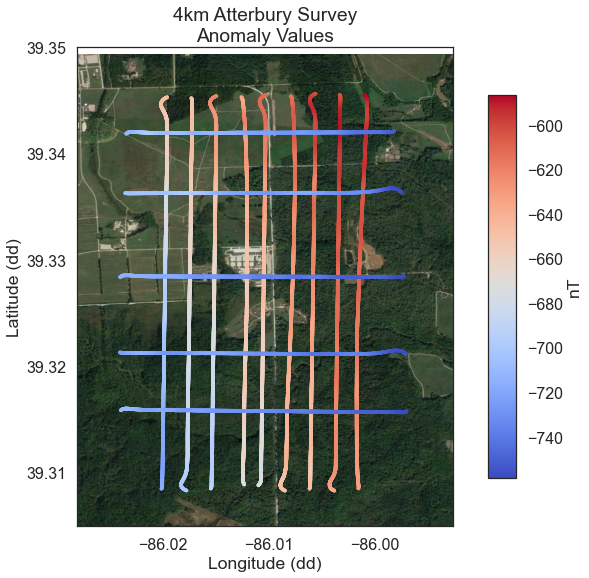

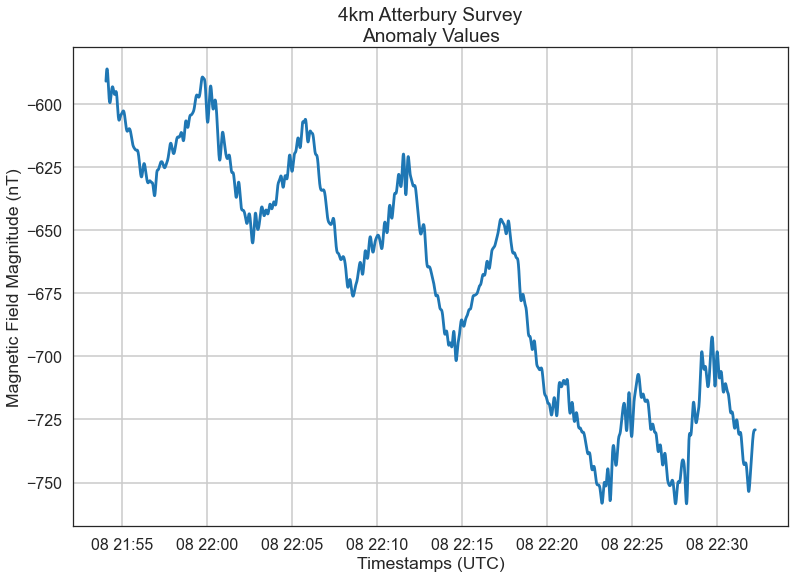

In [6]:
f_cal_igrf               = f_cal - log_df.IGRF_F
f_cal_igrf_temporal      = f_cal_igrf - ref_mag
f_cal_igrf_temporal_filt = filt.lpf(f_cal_igrf_temporal, MAX_EXPECTED_FREQ, sample_rate)

process_dict = {'TIMESTAMP':  timestamps,
                'LAT':        log_df.LAT,
                'LONG':       log_df.LONG,
                'ALT':        log_df.ALT,
                'DC_X':       dc_x,
                'DC_Y':       dc_y,
                'DC_Z':       dc_z,
                'F':          f,
                'F_CAL':      f_cal,
                'F_CAL_IGRF': f_cal_igrf,
                'F_CAL_IGRF_TEMPORAL': f_cal_igrf_temporal,
                'F_CAL_IGRF_TEMPORAL_FILT': f_cal_igrf_temporal_filt}

log_df.F = f_cal_igrf_temporal_filt

plt.figure()
plt.title('{}\nAnomaly Values'.format(SURVEY_NAME))
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.imshow(img, extent=GMAP_EXTENT)
cb = plt.scatter(log_df.LONG[log_df.LINE_TYPE != 0],
                 log_df.LAT[log_df.LINE_TYPE != 0],
                 s=s,
                 c=log_df.F[log_df.LINE_TYPE != 0],
                 cmap=cmap)
plt.xlim(xlims)
plt.ylim(ylims)
plt.colorbar(cb, label='nT', shrink=shrink, aspect=aspect)

plt.figure()
plt.title('{}\nAnomaly Values'.format(SURVEY_NAME))
plt.xlabel('Timestamps (UTC)')
plt.ylabel('Magnetic Field Magnitude (nT)')
plt.plot(log_df.datetime, log_df.F)
plt.grid()

# Crop Map Extent

In [7]:
MIN_MAP_LAT = 39.3127
MAX_MAP_LAT = 39.3427

# Create Maps Based on Non-Leveled Flight Lines

Interpolating survey anomaly data to map coordinates
Running radial basis function (RBF) interpolation for all map pixels


Text(0.5, 1.0, 'Map From Exported GeoTIFF')

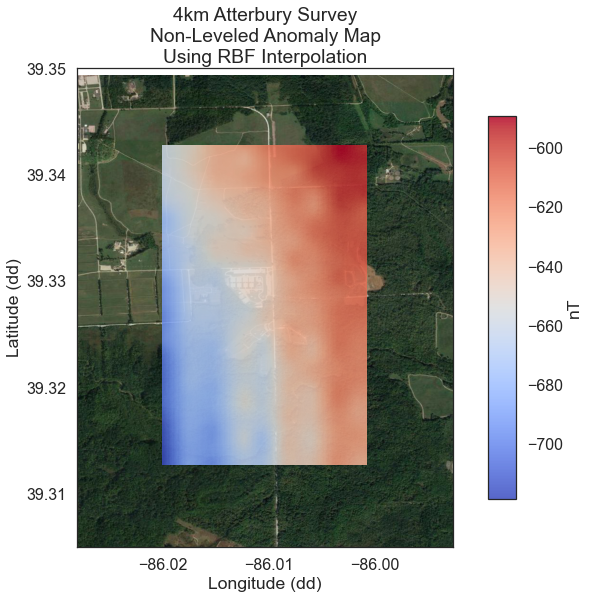

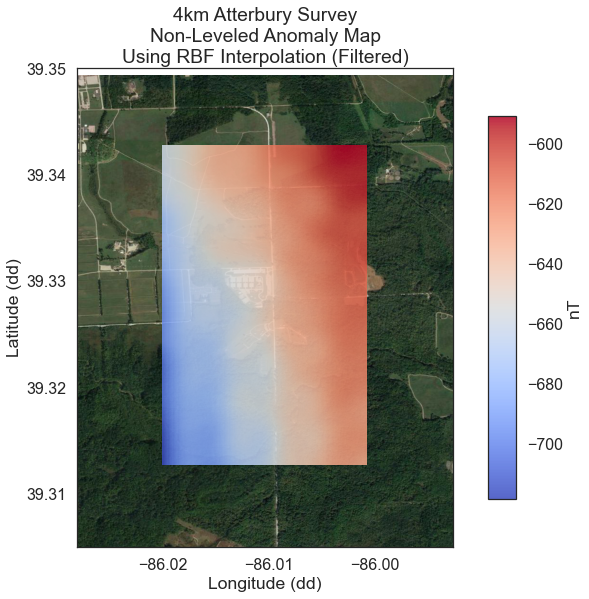

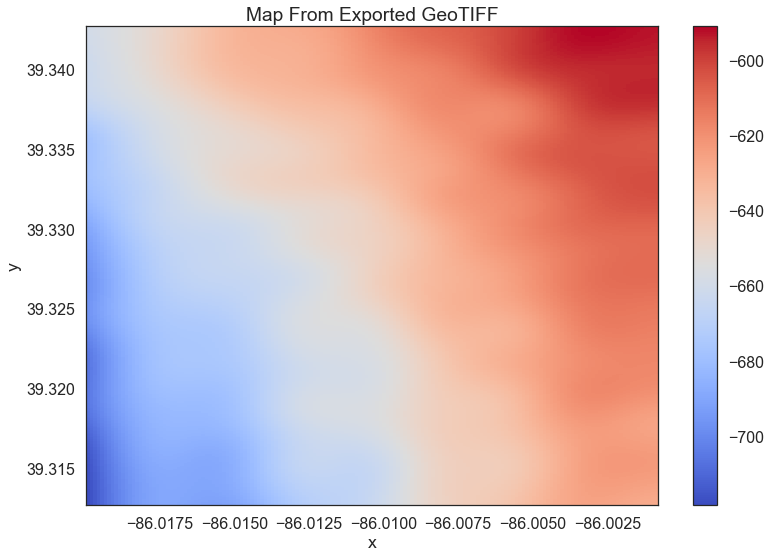

In [8]:
interp_type = 'RBF'
interp_df = pu.interp_flight_lines(anomaly_df      = log_df[(log_df.LAT >= MIN_MAP_LAT) & (log_df.LAT <= MAX_MAP_LAT)],
                                   dx              = DX,
                                   dy              = DY,
                                   max_terrain_msl = MAX_TERRAIN_MSL,
                                   buffer          = 0,
                                   interp_type     = interp_type,
                                   neighbors       = None,
                                   skip_na_mask    = True)

interp_lats    = interp_df['LAT']
interp_lons    = interp_df['LONG']
interp_scalar  = interp_df['F']
interp_heights = interp_df['ALT']
interp_std     = interp_df['STD']

interp_scalar_LPF = filt.lpf2(interp_scalar,
                              MAX_SURVEY_AGL,
                              DX,
                              DY)

map_title = '{}\nNon-Leveled Anomaly Map\nUsing {} Interpolation'.format(SURVEY_NAME, interp_type)

plt.figure()
plt.title(map_title)
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.imshow(img, extent=GMAP_EXTENT)
cb = plt.pcolormesh(interp_lons,
                    interp_lats,
                    interp_scalar,
                    cmap=cmap,
                    alpha=alpha)
plt.colorbar(cb, label='nT', shrink=shrink, aspect=aspect)
plt.xlim(xlims)
plt.ylim(ylims)

map_title = '{}\nNon-Leveled Anomaly Map\nUsing {} Interpolation (Filtered)'.format(SURVEY_NAME, interp_type)

plt.figure()
plt.title(map_title)
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.imshow(img, extent=GMAP_EXTENT)
cb = plt.pcolormesh(interp_lons,
                    interp_lats,
                    interp_scalar_LPF,
                    cmap=cmap,
                    alpha=alpha)
plt.colorbar(cb, label='nT', shrink=shrink, aspect=aspect)
plt.xlim(xlims)
plt.ylim(ylims)

extent = [interp_lons.min(), interp_lats.min(), interp_lons.max(), interp_lats.max()]
xmin, ymin, xmax, ymax = extent

flight_path = np.hstack([np.array(log_df.LAT)[:, np.newaxis],
                         np.array(log_df.LONG)[:, np.newaxis],
                         np.array(log_df.ALT)[:, np.newaxis],
                         np.array(log_df.epoch_sec)[:, np.newaxis]])
area_polys = [{'NAME':    'Survey Area',
               'FL_DIR':  0,
               'FL_DIST': 200,
               'TL_DIR':  90,
               'TL_DIST': 200,
               'LAT':     [ymax, ymax, ymin, ymin, ymax],
               'LONG':    [xmin, xmax, xmax, xmin, xmin],
               'ALT':     [MAX_TERRAIN_MSL + MAX_SURVEY_AGL] * 5}]

process_dict['F_CAL_IGRF_TEMPORAL_FILT_LEVEL'] = f_cal_igrf_temporal_filt

# Export map as a GeoTIFF
map = mu.export_map(out_dir          = OUT_DIR,
                    location         = ' '.join(map_title.split()),
                    date             = log_df.datetime[0],
                    lats             = interp_lats,
                    lons             = interp_lons,
                    scalar           = interp_scalar_LPF,
                    heights          = interp_heights,
                    process_df       = pd.DataFrame(process_dict),
                    process_app      = PROCESS_APP,
                    stds             = interp_std,
                    vector           = None,
                    scalar_type      = SCALAR_TYPE,
                    vector_type      = VECTOR_TYPE,
                    scalar_var       = np.nan,
                    vector_var       = np.nan,
                    poc              = POC,
                    flight_path      = flight_path,
                    area_polys       = area_polys,
                    osm_path         = None,
                    level_type       = 'No leveling',
                    tl_coeff_types   = TL_COEFF_TYPES,
                    tl_coeffs        = TL_C,
                    interp_type      = interp_type,
                    final_filt_cut   = FINAL_FILT_CUT,
                    final_filt_order = FINAL_FILT_ORDER)

plt.figure()
map[0].plot(cmap=cm.coolwarm)
plt.title('Map From Exported GeoTIFF')

# Apply PCA-Based Flight Line Leveling

(39.305, 39.35)

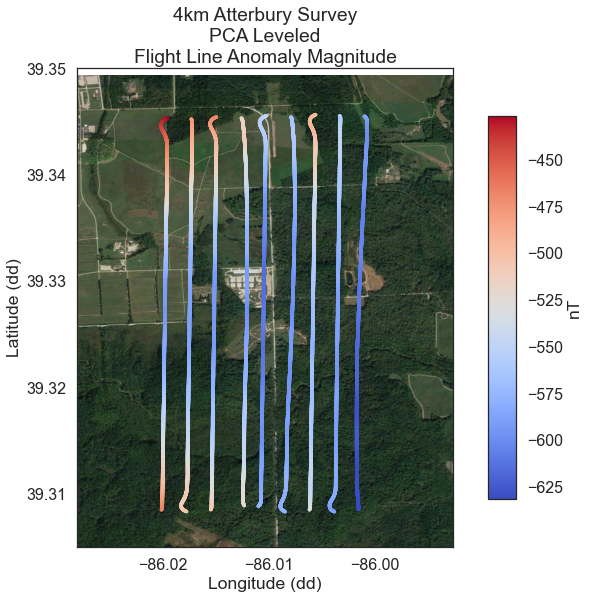

In [9]:
lvld_survey_df = pcaLvl.pca_lvl(survey_df = log_df,
                                num_ptls  = 2,
                                ptl_locs  = np.array([0.25, 0.75]))

plt.figure()
plt.title('{}\nPCA Leveled\nFlight Line Anomaly Magnitude'.format(SURVEY_NAME))
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.imshow(img, extent=GMAP_EXTENT)
cb = plt.scatter(lvld_survey_df.LONG[lvld_survey_df.LINE_TYPE == 1],
                 lvld_survey_df.LAT[lvld_survey_df.LINE_TYPE == 1],
                 s=s,
                 c=lvld_survey_df.F[lvld_survey_df.LINE_TYPE == 1],
                 cmap=cmap)
plt.colorbar(cb, label='nT', shrink=shrink, aspect=aspect)
plt.xlim(xlims)
plt.ylim(ylims)

# Create Maps Based on PCA-Leveled Flight Lines

Interpolating survey anomaly data to map coordinates
Running radial basis function (RBF) interpolation for all map pixels


Text(0.5, 1.0, 'Map From Exported GeoTIFF')

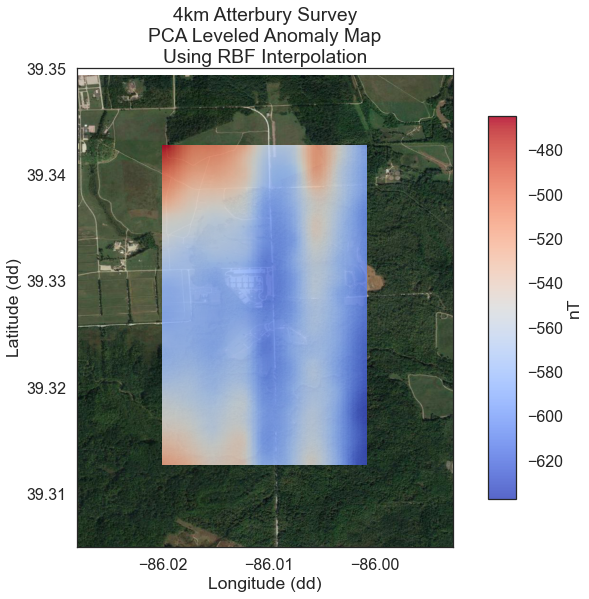

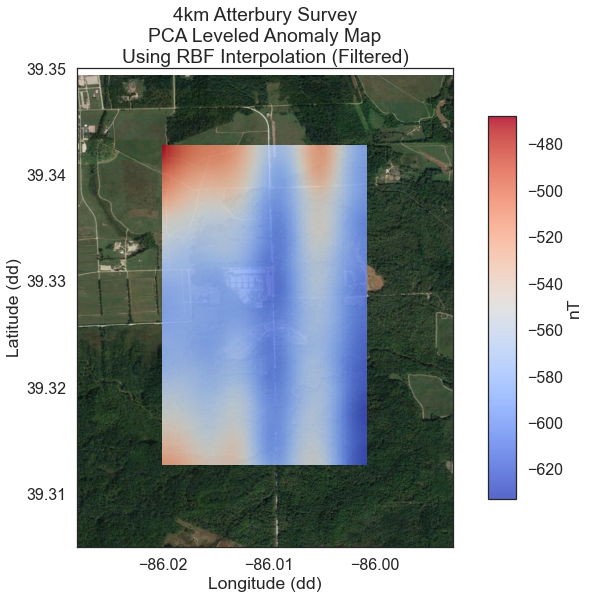

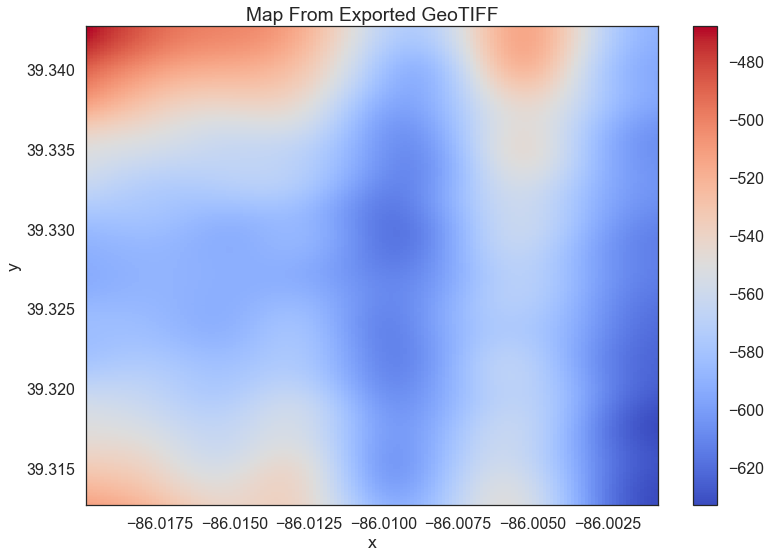

In [10]:
interp_type = 'RBF'
interp_df = pu.interp_flight_lines(anomaly_df      = lvld_survey_df[(lvld_survey_df.LAT >= MIN_MAP_LAT) & (lvld_survey_df.LAT <= MAX_MAP_LAT)],
                                   dx              = DX,
                                   dy              = DY,
                                   max_terrain_msl = MAX_TERRAIN_MSL,
                                   buffer          = 0,
                                   interp_type     = interp_type,
                                   neighbors       = None,
                                   skip_na_mask    = True)

interp_lats    = interp_df['LAT']
interp_lons    = interp_df['LONG']
interp_scalar  = interp_df['F']
interp_heights = interp_df['ALT']
interp_std     = interp_df['STD']

interp_scalar_LPF = filt.lpf2(interp_scalar,
                              MAX_SURVEY_AGL,
                              DX,
                              DY)

map_title = '{}\nPCA Leveled Anomaly Map\nUsing {} Interpolation'.format(SURVEY_NAME, interp_type)

plt.figure()
plt.title(map_title)
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.imshow(img, extent=GMAP_EXTENT)
cb = plt.pcolormesh(interp_lons,
                    interp_lats,
                    interp_scalar,
                    cmap=cmap,
                    alpha=alpha)
plt.colorbar(cb, label='nT', shrink=shrink, aspect=aspect)
plt.xlim(xlims)
plt.ylim(ylims)

map_title = '{}\nPCA Leveled Anomaly Map\nUsing {} Interpolation (Filtered)'.format(SURVEY_NAME, interp_type)

plt.figure()
plt.title(map_title)
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.imshow(img, extent=GMAP_EXTENT)
cb = plt.pcolormesh(interp_lons,
                    interp_lats,
                    interp_scalar_LPF,
                    cmap=cmap,
                    alpha=alpha)
plt.colorbar(cb, label='nT', shrink=shrink, aspect=aspect)
plt.xlim(xlims)
plt.ylim(ylims)

process_dict['F_CAL_IGRF_TEMPORAL_FILT_LEVEL'] = lvld_survey_df.F

# Export map as a GeoTIFF
map = mu.export_map(out_dir          = OUT_DIR,
                    location         = ' '.join(map_title.split()),
                    date             = log_df.datetime[0],
                    lats             = interp_lats,
                    lons             = interp_lons,
                    scalar           = interp_scalar_LPF,
                    heights          = interp_heights,
                    process_df       = pd.DataFrame(process_dict),
                    process_app      = PROCESS_APP,
                    stds             = interp_std,
                    vector           = None,
                    scalar_type      = SCALAR_TYPE,
                    vector_type      = VECTOR_TYPE,
                    scalar_var       = np.nan,
                    vector_var       = np.nan,
                    poc              = POC,
                    flight_path      = flight_path,
                    area_polys       = area_polys,
                    osm_path         = None,
                    level_type       = 'PCA pseudo tie line leveling',
                    tl_coeff_types   = TL_COEFF_TYPES,
                    tl_coeffs        = TL_C,
                    interp_type      = interp_type,
                    final_filt_cut   = FINAL_FILT_CUT,
                    final_filt_order = FINAL_FILT_ORDER)

plt.figure()
map[0].plot(cmap=cm.coolwarm)
plt.title('Map From Exported GeoTIFF')

# Apply Per Flight Line Tie Line-Based Flight Line Leveling

(39.305, 39.35)

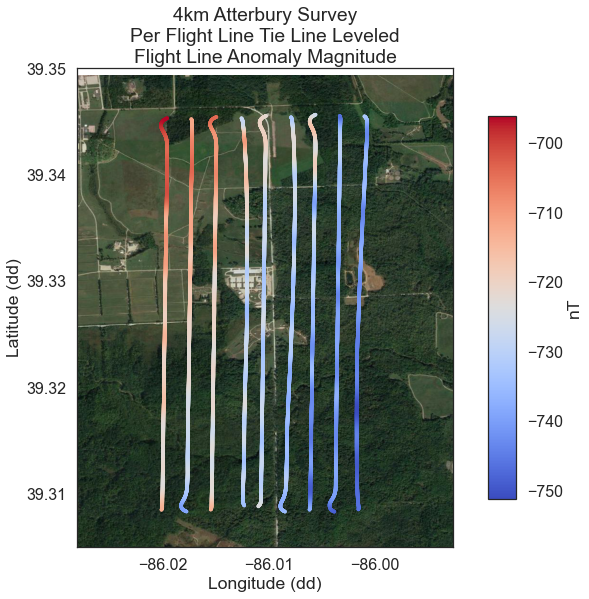

In [11]:
lvld_survey_df = tieLvl.tie_lvl(survey_df = log_df,
                                approach  = 'lobf')

plt.figure()
plt.title('{}\nPer Flight Line Tie Line Leveled\nFlight Line Anomaly Magnitude'.format(SURVEY_NAME))
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.imshow(img, extent=GMAP_EXTENT)
cb = plt.scatter(lvld_survey_df.LONG[lvld_survey_df.LINE_TYPE == 1],
                 lvld_survey_df.LAT[lvld_survey_df.LINE_TYPE == 1],
                 s=s,
                 c=lvld_survey_df.F[lvld_survey_df.LINE_TYPE == 1],
                 cmap=cmap)
plt.colorbar(cb, label='nT', shrink=shrink, aspect=aspect)
plt.xlim(xlims)
plt.ylim(ylims)

# Create Map Based on Per Flight Line Tie Line-Leveled Flight Lines

Interpolating survey anomaly data to map coordinates
Running radial basis function (RBF) interpolation for all map pixels


Text(0.5, 1.0, 'Map From Exported GeoTIFF')

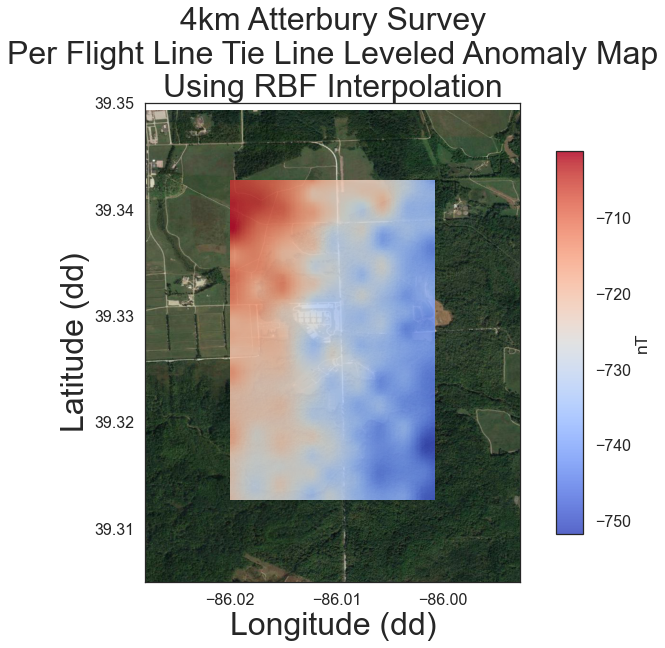

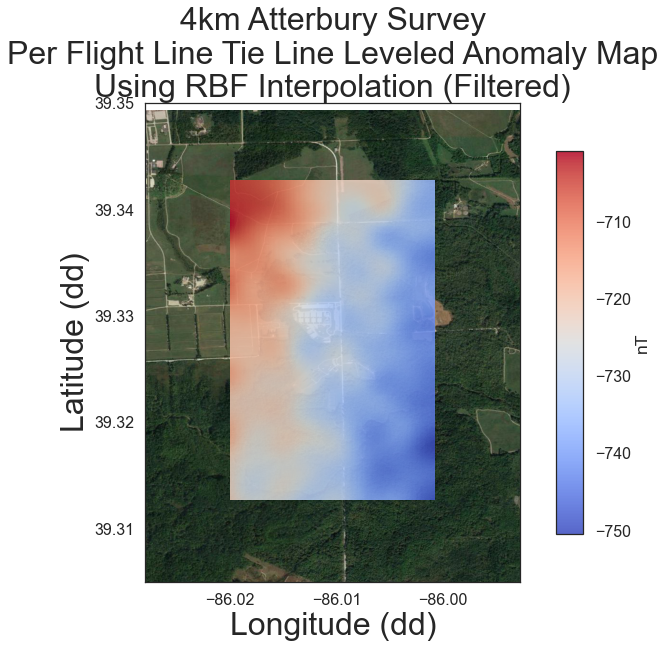

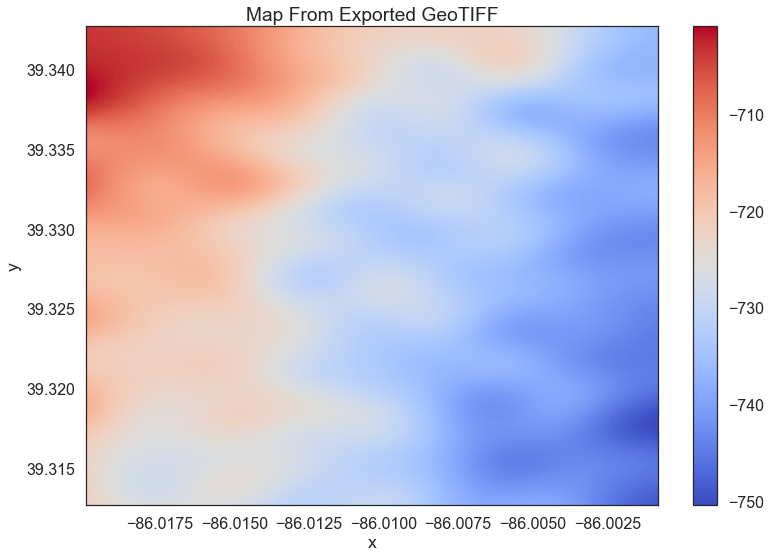

In [12]:
interp_type = 'RBF'
interp_df = pu.interp_flight_lines(anomaly_df      = lvld_survey_df[(lvld_survey_df.LAT >= MIN_MAP_LAT) & (lvld_survey_df.LAT <= MAX_MAP_LAT)],
                                   dx              = DX,
                                   dy              = DY,
                                   max_terrain_msl = MAX_TERRAIN_MSL,
                                   buffer          = 0,
                                   interp_type     = interp_type,
                                   neighbors       = None,
                                   skip_na_mask    = True)

interp_lats    = interp_df['LAT']
interp_lons    = interp_df['LONG']
interp_scalar  = interp_df['F']
interp_heights = interp_df['ALT']
interp_std     = interp_df['STD']

interp_scalar_LPF = filt.lpf2(interp_scalar,
                              MAX_SURVEY_AGL,
                              DX,
                              DY)

map_title = '{}\nPer Flight Line Tie Line Leveled Anomaly Map\nUsing {} Interpolation'.format(SURVEY_NAME, interp_type)

plt.figure()
plt.title(map_title, fontsize=32)
plt.xlabel('Longitude (dd)', fontsize=32)
plt.ylabel('Latitude (dd)', fontsize=32)
plt.imshow(img, extent=GMAP_EXTENT)
cb = plt.pcolormesh(interp_lons,
                    interp_lats,
                    interp_scalar,
                    cmap=cmap,
                    alpha=alpha)
plt.colorbar(cb, label='nT', shrink=shrink, aspect=aspect)
plt.xlim(xlims)
plt.ylim(ylims)

map_title = '{}\nPer Flight Line Tie Line Leveled Anomaly Map\nUsing {} Interpolation (Filtered)'.format(SURVEY_NAME, interp_type)

plt.figure()
plt.title(map_title, fontsize=32)
plt.xlabel('Longitude (dd)', fontsize=32)
plt.ylabel('Latitude (dd)', fontsize=32)
plt.imshow(img, extent=GMAP_EXTENT)
cb = plt.pcolormesh(interp_lons,
                    interp_lats,
                    interp_scalar_LPF,
                    cmap=cmap,
                    alpha=alpha)
plt.colorbar(cb, label='nT', shrink=shrink, aspect=aspect)
plt.xlim(xlims)
plt.ylim(ylims)

process_dict['F_CAL_IGRF_TEMPORAL_FILT_LEVEL'] = lvld_survey_df.F

# Export map as a GeoTIFF
map = mu.export_map(out_dir          = OUT_DIR,
                    location         = ' '.join(map_title.split()),
                    date             = log_df.datetime[0],
                    lats             = interp_lats,
                    lons             = interp_lons,
                    scalar           = interp_scalar_LPF,
                    heights          = interp_heights,
                    process_df       = pd.DataFrame(process_dict),
                    process_app      = PROCESS_APP,
                    stds             = interp_std,
                    vector           = None,
                    scalar_type      = SCALAR_TYPE,
                    vector_type      = VECTOR_TYPE,
                    scalar_var       = np.nan,
                    vector_var       = np.nan,
                    poc              = POC,
                    flight_path      = flight_path,
                    area_polys       = area_polys,
                    osm_path         = None,
                    level_type       = 'Per flight line tie line leveling',
                    tl_coeff_types   = TL_COEFF_TYPES,
                    tl_coeffs        = TL_C,
                    interp_type      = interp_type,
                    final_filt_cut   = FINAL_FILT_CUT,
                    final_filt_order = FINAL_FILT_ORDER)

plt.figure()
map[0].plot(cmap=cm.coolwarm)
plt.title('Map From Exported GeoTIFF')

# Apply Plane of Best Fit Tie Line-Based Flight Line Leveling

(39.305, 39.35)

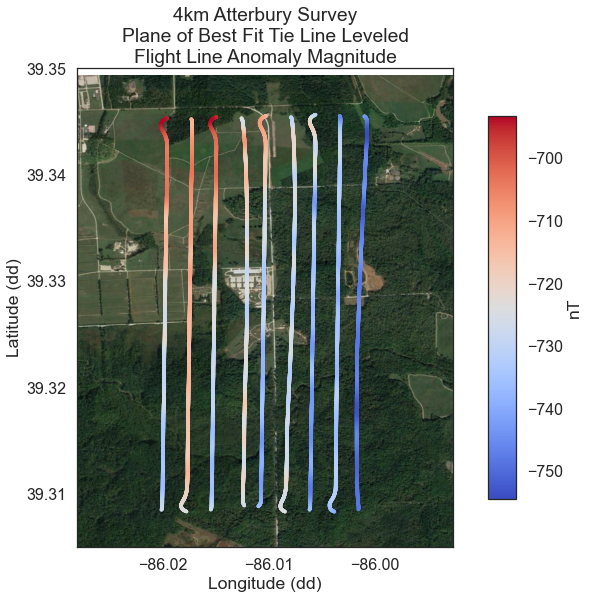

In [13]:
lvld_survey_df = tieLvl.tie_lvl(survey_df = log_df,
                                approach  = 'lsq')

plt.figure()
plt.title('{}\nPlane of Best Fit Tie Line Leveled\nFlight Line Anomaly Magnitude'.format(SURVEY_NAME))
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.imshow(img, extent=GMAP_EXTENT)
cb = plt.scatter(lvld_survey_df.LONG[lvld_survey_df.LINE_TYPE == 1],
                 lvld_survey_df.LAT[lvld_survey_df.LINE_TYPE == 1],
                 s=s,
                 c=lvld_survey_df.F[lvld_survey_df.LINE_TYPE == 1],
                 cmap=cmap)
plt.colorbar(cb, label='nT', shrink=shrink, aspect=aspect)
plt.xlim(xlims)
plt.ylim(ylims)

# Create Map Based on Plane of Best Fit Tie Line-Leveled Flight Lines

Interpolating survey anomaly data to map coordinates
Running radial basis function (RBF) interpolation for all map pixels


Text(0.5, 1.0, 'Map From Exported GeoTIFF')

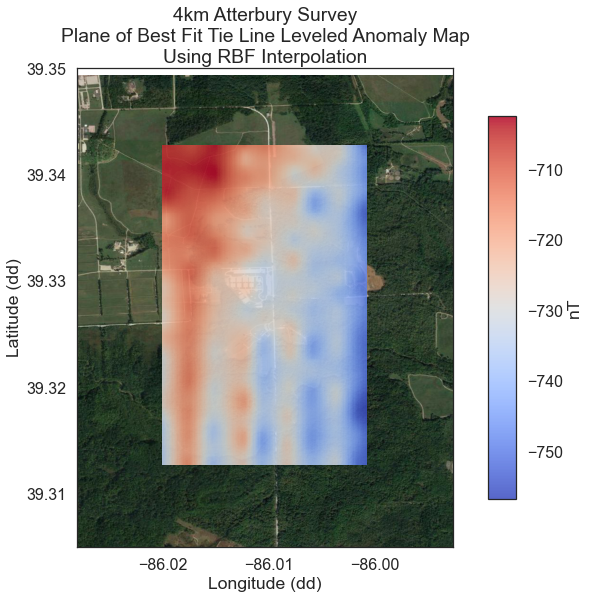

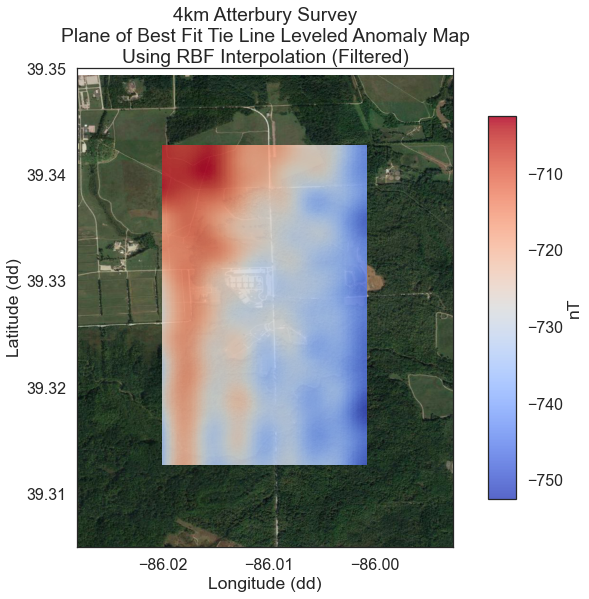

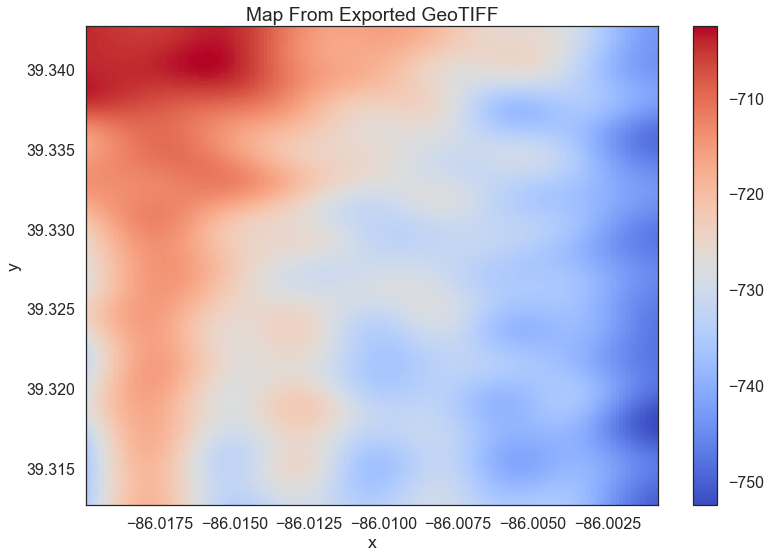

In [14]:
interp_type = 'RBF'
interp_df = pu.interp_flight_lines(anomaly_df      = lvld_survey_df[(lvld_survey_df.LAT >= MIN_MAP_LAT) & (lvld_survey_df.LAT <= MAX_MAP_LAT)],
                                   dx              = DX,
                                   dy              = DY,
                                   max_terrain_msl = MAX_TERRAIN_MSL,
                                   buffer          = 0,
                                   interp_type     = interp_type,
                                   neighbors       = None,
                                   skip_na_mask    = True)

interp_lats    = interp_df['LAT']
interp_lons    = interp_df['LONG']
interp_scalar  = interp_df['F']
interp_heights = interp_df['ALT']
interp_std     = interp_df['STD']

interp_scalar_LPF = filt.lpf2(interp_scalar,
                              MAX_SURVEY_AGL,
                              DX,
                              DY)

map_title = '{}\nPlane of Best Fit Tie Line Leveled Anomaly Map\nUsing {} Interpolation'.format(SURVEY_NAME, interp_type)

plt.figure()
plt.title(map_title)
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.imshow(img, extent=GMAP_EXTENT)
cb = plt.pcolormesh(interp_lons,
                    interp_lats,
                    interp_scalar,
                    cmap=cmap,
                    alpha=alpha)
plt.colorbar(cb, label='nT', shrink=shrink, aspect=aspect)
plt.xlim(xlims)
plt.ylim(ylims)

map_title = '{}\nPlane of Best Fit Tie Line Leveled Anomaly Map\nUsing {} Interpolation (Filtered)'.format(SURVEY_NAME, interp_type)

plt.figure()
plt.title(map_title)
plt.xlabel('Longitude (dd)')
plt.ylabel('Latitude (dd)')
plt.imshow(img, extent=GMAP_EXTENT)
cb = plt.pcolormesh(interp_lons,
                    interp_lats,
                    interp_scalar_LPF,
                    cmap=cmap,
                    alpha=alpha)
plt.colorbar(cb, label='nT', shrink=shrink, aspect=aspect)
plt.xlim(xlims)
plt.ylim(ylims)

process_dict['F_CAL_IGRF_TEMPORAL_FILT_LEVEL'] = lvld_survey_df.F

# Export map as a GeoTIFF
map = mu.export_map(out_dir          = OUT_DIR,
                    location         = ' '.join(map_title.split()),
                    date             = log_df.datetime[0],
                    lats             = interp_lats,
                    lons             = interp_lons,
                    scalar           = interp_scalar_LPF,
                    heights          = interp_heights,
                    process_df       = pd.DataFrame(process_dict),
                    process_app      = PROCESS_APP,
                    stds             = interp_std,
                    vector           = None,
                    scalar_type      = SCALAR_TYPE,
                    vector_type      = VECTOR_TYPE,
                    scalar_var       = np.nan,
                    vector_var       = np.nan,
                    poc              = POC,
                    flight_path      = flight_path,
                    area_polys       = area_polys,
                    osm_path         = None,
                    level_type       = 'Plane of best fit tie line leveling',
                    tl_coeff_types   = TL_COEFF_TYPES,
                    tl_coeffs        = TL_C,
                    interp_type      = interp_type,
                    final_filt_cut   = FINAL_FILT_CUT,
                    final_filt_order = FINAL_FILT_ORDER)

plt.figure()
map[0].plot(cmap=cm.coolwarm)
plt.title('Map From Exported GeoTIFF')